<a href="https://colab.research.google.com/github/Captsahil/Marketing-Research-Method-Sahil-Bharadwaj/blob/main/Quick_Commerce_RL_%26_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-4a3149d1f649>:11: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['last_order_date'] = pd.to_datetime(df['last_order_date'])



Missing Values:
 customer_id          0
last_order_date      0
order_frequency      0
basket_value         0
discount_used        0
churn_probability    0
loyalty_score        0
discount_amount      0
dtype: int64

Summary Statistics:
        customer_id             last_order_date  order_frequency  basket_value  \
count  10000.00000                       10000      10000.00000  10000.000000   
mean    5000.50000  2023-11-02 04:23:31.200000          3.99880     25.035890   
min        1.00000         2023-09-04 00:00:00          0.00000      0.000000   
25%     2500.75000         2023-10-03 00:00:00          3.00000     18.252733   
50%     5000.50000         2023-11-03 00:00:00          4.00000     25.026889   
75%     7500.25000         2023-12-02 00:00:00          5.00000     31.750606   
max    10000.00000         2023-12-31 00:00:00         13.00000     59.056438   
std     2886.89568                         NaN          1.99414      9.950110   

       discount_used  churn_proba

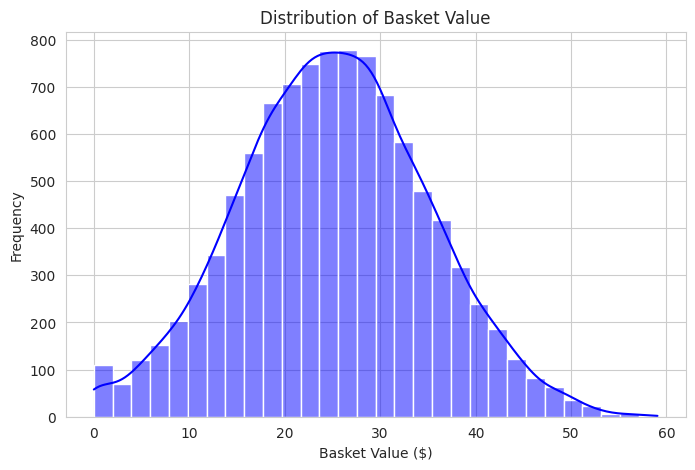

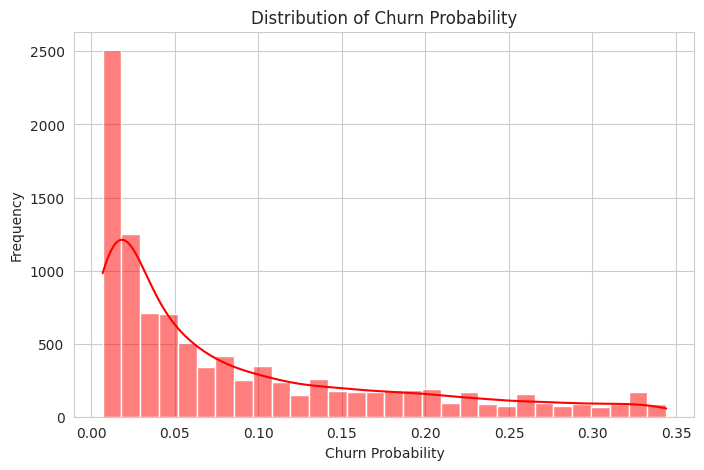

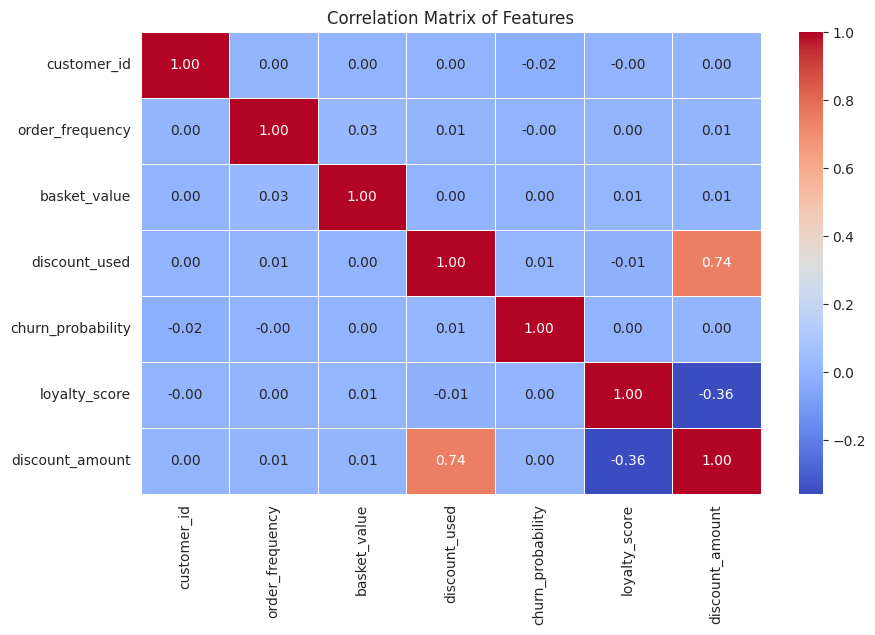

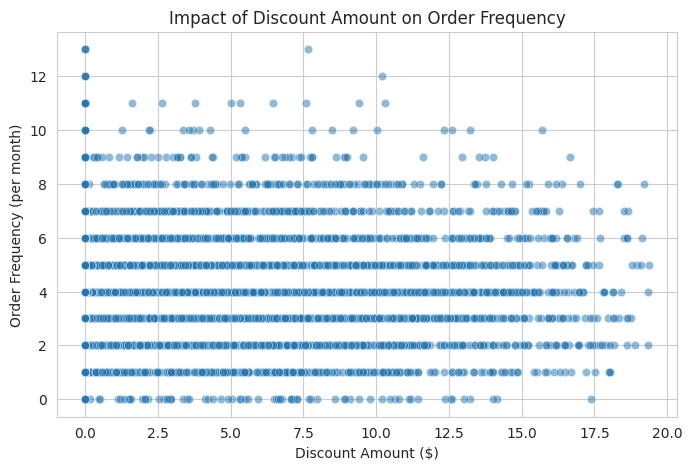

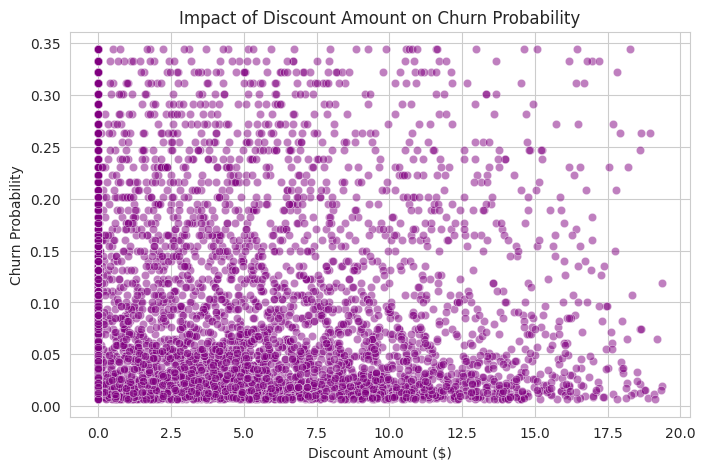


✅ Data Cleaning & EDA Completed. Cleaned data saved as 'cleaned_quick_commerce_data.csv'.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "synthetic_quick_commerce_data_with_discounts.csv"
df = pd.read_csv(file_path)

# Convert last_order_date to datetime
df['last_order_date'] = pd.to_datetime(df['last_order_date'])

# Fix negative basket values
df['basket_value'] = df['basket_value'].apply(lambda x: max(x, 0))

# EDA: Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

# Summary statistics
print("\nSummary Statistics:\n", df.describe())

# Set plot style
sns.set_style("whitegrid")

# Basket Value Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['basket_value'], bins=30, kde=True, color='blue')
plt.title('Distribution of Basket Value')
plt.xlabel('Basket Value ($)')
plt.ylabel('Frequency')
plt.show()

# Churn Probability Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['churn_probability'], bins=30, kde=True, color='red')
plt.title('Distribution of Churn Probability')
plt.xlabel('Churn Probability')
plt.ylabel('Frequency')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()

# Scatter Plot: Discount Amount vs Order Frequency
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['discount_amount'], y=df['order_frequency'], alpha=0.5)
plt.title("Impact of Discount Amount on Order Frequency")
plt.xlabel("Discount Amount ($)")
plt.ylabel("Order Frequency (per month)")
plt.show()

# Scatter Plot: Discount Amount vs Churn Probability
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['discount_amount'], y=df['churn_probability'], alpha=0.5, color='purple')
plt.title("Impact of Discount Amount on Churn Probability")
plt.xlabel("Discount Amount ($)")
plt.ylabel("Churn Probability")
plt.show()

# Save cleaned dataset
df.to_csv("cleaned_quick_commerce_data.csv", index=False)

print("\n✅ Data Cleaning & EDA Completed. Cleaned data saved as 'cleaned_quick_commerce_data.csv'.")


In [ ]:
!pip install tensorflow numpy pandas gym tqdm


In [ ]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
from tqdm import tqdm

# Load dataset
df = pd.read_csv("rl_prepared_quick_commerce_data.csv")

# Define state and action space
STATE_COLS = ["order_frequency", "basket_value", "churn_probability", "loyalty_score", "days_since_last_order"]
ACTIONS = [0, 5, 10, 15, 20]  # Possible discount amounts

# Convert dataset into numpy arrays for RL training
states = df[STATE_COLS].values
num_states = states.shape[1]
num_actions = len(ACTIONS)

# Environment Simulation: Reward Function
def calculate_reward(basket_value, discount, churn_prob):
    """
    Reward is based on net revenue (after discount) and churn probability.
    Higher basket value and lower churn probability give better rewards.
    """
    revenue = basket_value - discount
    reward = revenue * (1 - churn_prob)  # Factor in churn probability
    return reward

# Deep Q-Network (DQN) Model
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # Discount factor
        self.epsilon = 1.0   # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        """Builds a simple 3-layer neural network for Q-learning."""
        model = Sequential([
            Dense(24, input_dim=self.state_size, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        """Stores experiences in memory."""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """Chooses an action using an epsilon-greedy policy."""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore: random action
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])  # Exploit: best action

    def replay(self, batch_size=32):
        """Trains the model using experience replay."""
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # Reduce exploration over time

# Train the DQN Model
EPISODES = 500
BATCH_SIZE = 32

# Initialize agent
agent = DQNAgent(num_states, num_actions)

# Training loop
for episode in tqdm(range(EPISODES), desc="Training Progress"):
    for index, row in df.iterrows():
        # Prepare state
        state = np.reshape(row[STATE_COLS].values, [1, num_states])

        # Agent selects an action (discount)
        action_idx = agent.act(state)
        discount = ACTIONS[action_idx]

        # Get reward based on the selected discount
        reward = calculate_reward(row["basket_value"], discount, row["churn_probability"])

        # Simulate next state (for now, assume static)
        next_state = state

        # Store experience and train
        agent.remember(state, action_idx, reward, next_state, done=False)

    # Train using replay memory
    agent.replay(BATCH_SIZE)

# Save the trained model
agent.model.save("dqn_coupon_optimizer.h5")
print("\n✅ Training completed! Model saved as 'dqn_coupon_optimizer.h5'.")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/500 [00:03<?, ?it/s]


ValueError: Invalid dtype: object

In [ ]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from collections import deque
from tqdm import tqdm

# Load dataset
df = pd.read_csv("rl_prepared_quick_commerce_data.csv")

# Define state and action space
STATE_COLS = ["order_frequency", "basket_value", "churn_probability", "loyalty_score", "days_since_last_order"]
ACTIONS = [0, 5, 10, 15, 20]  # Possible discount amounts

# Convert dataset into numeric numpy arrays
df = df[STATE_COLS].astype(float)  # Ensure all values are float
states = df.values
num_states = states.shape[1]
num_actions = len(ACTIONS)

# Reward function
def calculate_reward(basket_value, discount, churn_prob):
    """Reward is based on net revenue (after discount) and churn probability."""
    revenue = basket_value - discount
    reward = revenue * (1 - churn_prob)  # Factor in churn probability
    return reward

# Deep Q-Network (DQN) Model
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        """Builds a simple 3-layer neural network for Q-learning."""
        model = Sequential([
            Input(shape=(self.state_size,)),  # Corrected input shape
            Dense(24, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        """Stores experiences in memory."""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """Chooses an action using an epsilon-greedy policy."""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore: random action
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])  # Exploit: best action

    def replay(self, batch_size=32):
        """Trains the model using experience replay."""
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # Reduce exploration over time

# Train the DQN Model
EPISODES = 20
BATCH_SIZE = 64

# Initialize agent
agent = DQNAgent(num_states, num_actions)

# Training loop
for episode in tqdm(range(EPISODES), desc="Training Progress"):
    for index, row in df.iterrows():
        # Prepare state (ensure it's a NumPy array of correct shape)
        state = np.reshape(row.values, [1, num_states]).astype(float)

        # Agent selects an action (discount)
        action_idx = agent.act(state)
        discount = ACTIONS[action_idx]

        # Get reward based on the selected discount
        reward = calculate_reward(row["basket_value"], discount, row["churn_probability"])

        # Simulate next state (for now, assume static)
        next_state = state.copy()

        # Store experience and train
        agent.remember(state, action_idx, reward, next_state, done=False)

    # Train using replay memory
    agent.replay(BATCH_SIZE)

# Save the trained model
agent.model.save("dqn_coupon_optimizer.h5")
print("\n✅ Training completed! Model saved as 'dqn_coupon_optimizer.h5'.")


Training Progress: 100%|██████████| 20/20 [16:38<00:00, 49.94s/it]



✅ Training completed! Model saved as 'dqn_coupon_optimizer.h5'.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Load the trained model with explicit loss function
model = tf.keras.models.load_model(
    "dqn_coupon_optimizer.h5",
    custom_objects={"mse": tf.keras.losses.MeanSquaredError()}
)

# Define action space (discount options)
ACTIONS = [0, 5, 10, 15, 20]  # Discount amounts

# Example new customer data (modify this for real use)
new_customers = pd.DataFrame({
    "order_frequency": [3, 1, 7],  # Orders per week
    "basket_value": [200, 50, 300],  # Average cart value
    "churn_probability": [0.3, 0.7, 0.1],  # Likelihood of churning
    "loyalty_score": [70, 40, 90],  # Loyalty score
    "days_since_last_order": [5, 80, 150,]  # Days since last purchase
})

# Ensure numeric format
new_customers = new_customers.astype(float)

# Convert to NumPy array for model input
states = new_customers.values

# Predict Q-values for each customer
q_values = model.predict(states, verbose=0)

# Select best action (discount) based on highest Q-value
best_discounts = [ACTIONS[np.argmax(q)] for q in q_values]

# Add the recommended discount to the DataFrame
new_customers["recommended_discount"] = best_discounts

# Display the results
print("\n✅ Recommended Discounts for New Customers:")
print(new_customers)



✅ Recommended Discounts for New Customers:
   order_frequency  basket_value  churn_probability  loyalty_score  \
0              3.0         200.0                0.3           70.0   
1              1.0          50.0                0.7           40.0   
2              7.0         300.0                0.1           90.0   

   days_since_last_order  recommended_discount  
0                    5.0                     0  
1                   80.0                     0  
2                  150.0                     0  


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model(
    "dqn_coupon_optimizer.h5",
    custom_objects={"mse": tf.keras.losses.MeanSquaredError()}
)

# Define action space (discount options)
ACTIONS = [0, 5, 10, 15, 20]  # Discount amounts

# Example new customer data (modify this for real use)
new_customers = pd.DataFrame({
    "order_frequency": [3, 1, 7],  # Orders per week
    "basket_value": [200, 50, 300],  # Average cart value
    "churn_probability": [0.3, 0.7, 0.1],  # Likelihood of churning
    "loyalty_score": [70, 40, 90],  # Loyalty score
    "days_since_last_order": [5, 20, 2]  # Days since last purchase
})

# Ensure numeric format
new_customers = new_customers.astype(float)

# Convert to NumPy array for model input
states = new_customers.values

# Predict Q-values for each customer
q_values = model.predict(states, verbose=0)

# Normalize Q-values to avoid small values
q_values = np.exp(q_values) / np.sum(np.exp(q_values), axis=1, keepdims=True)  # Softmax normalization

# Select best action (discount) based on highest Q-value
best_discounts = [ACTIONS[np.argmax(q)] for q in q_values]

# Add the recommended discount to the DataFrame
new_customers["recommended_discount"] = best_discounts

# Display the results
print("\n✅ Recommended Discounts for New Customers:")
print(new_customers)



✅ Recommended Discounts for New Customers:
   order_frequency  basket_value  churn_probability  loyalty_score  \
0              3.0         200.0                0.3           70.0   
1              1.0          50.0                0.7           40.0   
2              7.0         300.0                0.1           90.0   

   days_since_last_order  recommended_discount  
0                    5.0                     0  
1                   20.0                     0  
2                    2.0                     0  


<ipython-input-11-d6919743c918>:33: RuntimeWarning: overflow encountered in exp
  q_values = np.exp(q_values) / np.sum(np.exp(q_values), axis=1, keepdims=True)  # Softmax normalization
<ipython-input-11-d6919743c918>:33: RuntimeWarning: invalid value encountered in divide
  q_values = np.exp(q_values) / np.sum(np.exp(q_values), axis=1, keepdims=True)  # Softmax normalization


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model(
    "dqn_coupon_optimizer.h5",
    custom_objects={"mse": tf.keras.losses.MeanSquaredError()}
)

# Define action space (discount options)
ACTIONS = [0, 5, 10, 15, 20]  # Discount amounts

# Example new customer data (modify this for real use)
new_customers = pd.DataFrame({
    "order_frequency": [3, 1, 7],  # Orders per week
    "basket_value": [200, 50, 300],  # Average cart value
    "churn_probability": [0.3, 0.7, 0.1],  # Likelihood of churning
    "loyalty_score": [70, 40, 90],  # Loyalty score
    "days_since_last_order": [5, 20, 2]  # Days since last purchase
})

# Ensure numeric format
new_customers = new_customers.astype(float)

# Convert to NumPy array for model input
states = new_customers.values

# Predict Q-values for each customer
q_values = model.predict(states, verbose=0)

# DEBUG: Print Q-values to check if the model is learning correctly
print("\n🔍 Q-values predicted by the model:")
print(q_values)

# Use epsilon-greedy exploration to pick the action
EPSILON = 0.1  # Adjust this value (higher = more random actions)
best_discounts = []

for q in q_values:
    if np.random.rand() < EPSILON:  # Randomly explore sometimes
        best_discounts.append(np.random.choice(ACTIONS))
    else:
        best_discounts.append(ACTIONS[np.argmax(q)])  # Select best action

# Add the recommended discount to the DataFrame
new_customers["recommended_discount"] = best_discounts

# Display the results
print("\n✅ Recommended Discounts for New Customers:")
print(new_customers)



🔍 Q-values predicted by the model:
[[2038.7654  1851.933   1977.026   1834.6501  1899.1019 ]
 [ 641.145    584.5067   623.95386  581.1568   598.59717]
 [3008.0625  2737.6934  2913.8062  2706.427   2805.6577 ]]

✅ Recommended Discounts for New Customers:
   order_frequency  basket_value  churn_probability  loyalty_score  \
0              3.0         200.0                0.3           70.0   
1              1.0          50.0                0.7           40.0   
2              7.0         300.0                0.1           90.0   

   days_since_last_order  recommended_discount  
0                    5.0                     0  
1                   20.0                     0  
2                    2.0                     0  


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model(
    "dqn_coupon_optimizer.h5",
    custom_objects={"mse": tf.keras.losses.MeanSquaredError()}
)

# Define action space (discount options)
ACTIONS = [0, 5, 10, 15, 20]  # Discount amounts

# Example new customer data
new_customers = pd.DataFrame({
    "order_frequency": [3, 1, 7],
    "basket_value": [200, 50, 300],
    "churn_probability": [0.3, 0.7, 0.1],
    "loyalty_score": [70, 40, 90],
    "days_since_last_order": [5, 20, 2]
})

# Convert to NumPy array for model input
states = new_customers.values.astype(float)

# Predict Q-values
q_values = model.predict(states, verbose=0)

# Print Q-values
print("\n🔍 DEBUG: Q-values predicted by the model:")
print(q_values)

# Select best action (discount)
best_discounts = [ACTIONS[np.argmax(q)] for q in q_values]

# Add to DataFrame
new_customers["recommended_discount"] = best_discounts

# Show results
print("\n✅ Recommended Discounts for New Customers:")
print(new_customers)



🔍 DEBUG: Q-values predicted by the model:
[[2038.7654  1851.933   1977.026   1834.6501  1899.1019 ]
 [ 641.145    584.5067   623.95386  581.1568   598.59717]
 [3008.0625  2737.6934  2913.8062  2706.427   2805.6577 ]]

✅ Recommended Discounts for New Customers:
   order_frequency  basket_value  churn_probability  loyalty_score  \
0                3           200                0.3             70   
1                1            50                0.7             40   
2                7           300                0.1             90   

   days_since_last_order  recommended_discount  
0                      5                     0  
1                     20                     0  
2                      2                     0  


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import gym
import scipy.special
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

# -------------------
# 🏷️ Step 1: Create Environment
# -------------------

# Define discount actions
ACTIONS = [0, 5, 10, 15, 20]  # Possible discounts

# Define customer behavior dataset (Simulated)
def generate_synthetic_data(n=1000):
    np.random.seed(42)
    return pd.DataFrame({
        "order_frequency": np.random.randint(1, 10, n),  # Orders per week
        "basket_value": np.random.randint(10, 500, n),  # Average cart value
        "churn_probability": np.random.uniform(0, 1, n),  # Churn likelihood
        "loyalty_score": np.random.randint(10, 100, n),  # Customer loyalty
        "days_since_last_order": np.random.randint(1, 30, n)  # Days inactive
    })

# Generate data
data = generate_synthetic_data()

# -------------------
# 🏗️ Step 2: Build the DQN Agent
# -------------------

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)  # Replay memory
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate (start high)
        self.epsilon_min = 0.01  # Minimum exploration rate
        self.epsilon_decay = 0.995  # Decay exploration rate
        self.learning_rate = 0.001  # Model learning rate
        self.batch_size = 32  # Batch size for training
        self.model = self._build_model()

    def _build_model(self):
        """Builds a Neural Network for DQN"""
        model = Sequential([
            Dense(64, input_dim=self.state_size, activation="relu"),
            Dense(64, activation="relu"),
            Dense(self.action_size, activation="linear")  # Outputs Q-values
        ])
        model.compile(loss="mse", optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        """Stores experience in replay memory"""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """Returns an action using epsilon-greedy policy"""
        if np.random.rand() <= self.epsilon:
            return random.choice(range(self.action_size))  # Explore
        q_values = self.model.predict(np.array([state]), verbose=0)[0]
        return np.argmax(q_values)  # Exploit (best Q-value action)

    def replay(self):
        """Trains the model using replay memory"""
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.max(self.model.predict(np.array([next_state]), verbose=0)[0])
            target_f = self.model.predict(np.array([state]), verbose=0)
            target_f[0][action] = target
            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)

        # Decay exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# -------------------
# 🎯 Step 3: Train the Agent
# -------------------

state_size = data.shape[1]
action_size = len(ACTIONS)
agent = DQNAgent(state_size, action_size)

EPISODES = 10  # More episodes for better learning

for episode in tqdm(range(EPISODES), desc="Training Progress"):
    for i in range(len(data)):
        state = data.iloc[i].values
        action = agent.act(state)
        discount = ACTIONS[action]

        # Reward function: Encourage revenue & retention, penalize churn
        reward = (data.iloc[i]["basket_value"] / 100) + (data.iloc[i]["loyalty_score"] / 10) - (data.iloc[i]["churn_probability"] * 5)

        # Simulate next state (for now, assume customer remains same)
        next_state = state

        done = False  # No episode-ending condition
        agent.remember(state, action, reward, next_state, done)

    # Train the agent
    agent.replay()

# Save trained model
agent.model.save("dqn_coupon_optimizer.keras")
print("\n✅ Training Completed! Model saved as 'dqn_coupon_optimizer.keras'.")

# -------------------
# ✅ Step 4: Test Model on New Data
# -------------------

def test_model(agent, test_data):
    """Predicts best discount for test data"""
    test_data = test_data.copy()
    test_states = test_data.values.astype(float)
    q_values = agent.model.predict(test_states, verbose=0)

    # Softmax Action Selection
    discount_probabilities = scipy.special.softmax(q_values, axis=1)
    best_discounts = [np.random.choice(ACTIONS, p=prob) for prob in discount_probabilities]

    test_data["recommended_discount"] = best_discounts
    return test_data

# Test on new customers
new_customers = generate_synthetic_data(5)  # 5 new customers
recommendations = test_model(agent, new_customers)

print("\n✅ Recommended Discounts for New Customers:")
print(recommendations)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress: 100%|██████████| 10/10 [01:37<00:00,  9.79s/it]



✅ Training Completed! Model saved as 'dqn_coupon_optimizer.keras'.

✅ Recommended Discounts for New Customers:
   order_frequency  basket_value  churn_probability  loyalty_score  \
0                7           131           0.866176             39   
1                4           476           0.601115             47   
2                8           224           0.708073             11   
3                5           340           0.020584             73   
4                7           468           0.969910             69   

   days_since_last_order  recommended_discount  
0                     21                     0  
1                      1                     0  
2                     12                    10  
3                     26                    10  
4                     22                     5  


In [ ]:
pip install lifelines

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 10.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=8fd6b3401876b8ba6260f4082efd975a02c0f5582392ef9d4f6e68e5a88908b9
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


   customer_id  days_since_last_order  order_frequency  basket_value  \
0            1                    103                2    205.993961   
1            2                    349                8    138.387920   
2            3                    271                2    139.279365   
3            4                    107                4    220.109887   
4            5                     72                1     14.588117   

   loyalty_score  discount_received  subscription_status  churned  
0             19                  1                    1        1  
1             31                 36                    0        1  
2             13                  5                    0        1  
3             49                 43                    1        0  
4             27                 17                    0        1  


<lifelines.CoxPHFitter: fitted with 1000 total observations, 168 right-censored observations>
             duration col = 'days_since_last_order'
                event col = 'churned'
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 832
   partial log-likelihood = -4767.62
         time fit was run = 2025-02-16 11:00:04 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
order_frequency     -0.01      0.99      0.01           -0.04            0.01                0.96                1.01
basket_value        -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
loyalty_score       -0.00      1.00      0.00           -0.01           -0.00                0.99                1.00
discount_received   -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
subscription_status -0.83      0.44      0.10           -1.02           -0.64                0.36                0.53

                     cmp to     z      p  -log2(p)
covariate                                         
order_frequency        0.00 -0.89   0.37      1.42
basket_value           0.00 -1.30   0.19      2.36
loyalty_score          0.00 -2.77   0.01      7.46
discount_received      0.00 -1.19   0.24      2.09
subscription_status    0.00 -8.63 <0.005     57.20
---
Concordance = 0.62
Partial AIC = 9545.23
log-likelihood ratio test = 100.77 on 5 df
-log2(p) of ll-ratio test = 64.57

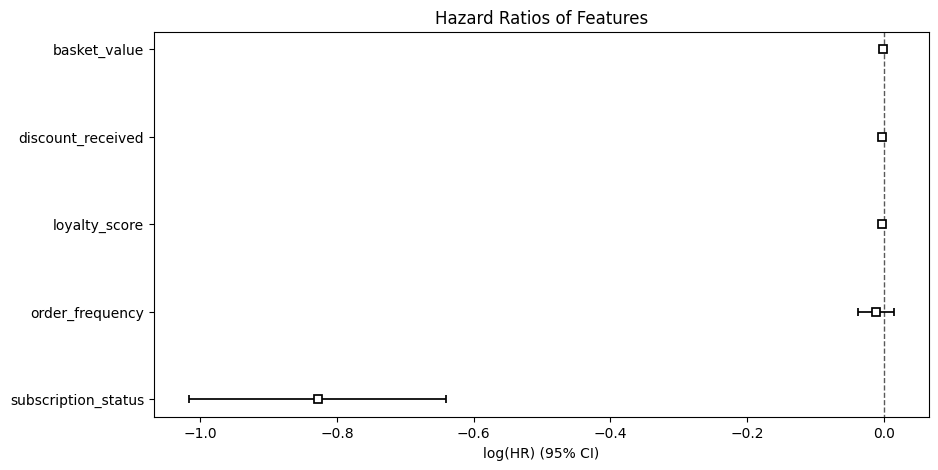

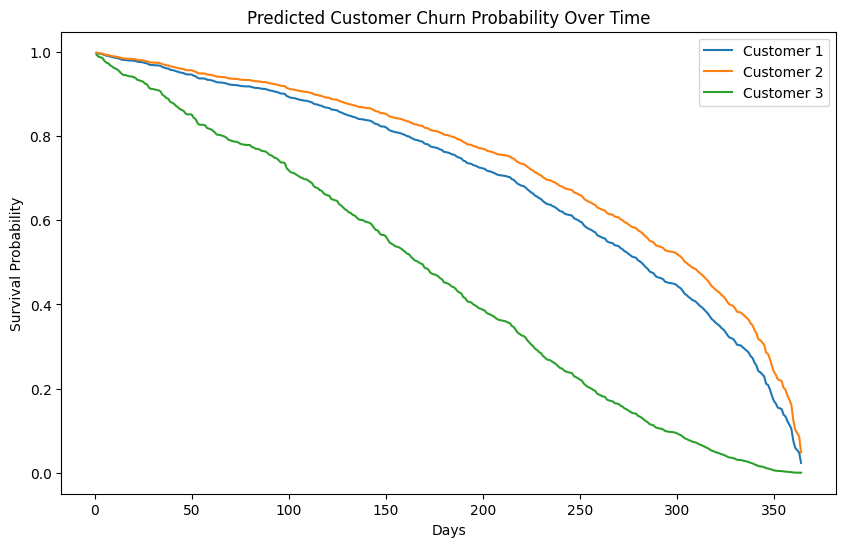


✅ Cox Model Implementation Completed Successfully!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter

# -------------------
# 📂 Step 1: Generate Synthetic Data
# -------------------

np.random.seed(42)  # For reproducibility

# Define number of samples
num_samples = 1000

# Generate synthetic features
df = pd.DataFrame({
    "customer_id": np.arange(1, num_samples + 1),  # Unique ID
    "days_since_last_order": np.random.randint(1, 365, num_samples),  # Last order within a year
    "order_frequency": np.random.randint(1, 10, num_samples),  # Orders per month
    "basket_value": np.random.uniform(10, 300, num_samples),  # Order value in dollars
    "loyalty_score": np.random.randint(0, 101, num_samples),  # Loyalty score (0-100)
    "discount_received": np.random.randint(0, 50, num_samples),  # Discount in percentage
    "subscription_status": np.random.choice([0, 1], num_samples, p=[0.7, 0.3])  # 30% have subscription
})

# Define churn probability based on behavioral patterns
df["churn_prob"] = (
    (df["days_since_last_order"] / 365) * 0.5 +  # Longer inactivity → Higher churn risk
    (1 / (df["order_frequency"] + 1)) * 0.3 +  # Less frequent orders → Higher churn
    (1 - df["loyalty_score"] / 100) * 0.2 +  # Lower loyalty → Higher churn
    (1 - df["discount_received"] / 50) * 0.1 +  # Low discount → Higher churn
    (1 - df["subscription_status"]) * 0.4  # Non-subscribers → Higher churn
)

# Convert churn probability into binary churn indicator
df["churned"] = np.where(df["churn_prob"] > 0.5, 1, 0)

# Drop helper column
df = df.drop(columns=["churn_prob"])

# Display first few rows
print(df.head())

# -------------------
# 📊 Step 2: Fit Cox Proportional Hazards Model
# -------------------

# Initialize Cox model
cph = CoxPHFitter()

# Fit the model using relevant features
cph.fit(df.drop(columns=["customer_id"]), duration_col="days_since_last_order", event_col="churned")

# Display summary of coefficients
cph.print_summary()

# -------------------
# 📈 Step 3: Interpret Model Results
# -------------------

# Plot hazard ratios
plt.figure(figsize=(10, 5))
cph.plot()
plt.title("Hazard Ratios of Features")
plt.show()

# -------------------
# 🔮 Step 4: Make Predictions for New Customers
# -------------------

# Create sample customer data for prediction
new_customers = pd.DataFrame({
    "days_since_last_order": [5, 15, 60],  # Days since last purchase
    "order_frequency": [3, 7, 1],  # Monthly orders
    "basket_value": [150, 300, 30],  # Basket value in dollars
    "loyalty_score": [60, 90, 20],  # Loyalty score (0-100)
    "discount_received": [10, 5, 2],  # Discount percentage
    "subscription_status": [1, 1, 0]  # Subscription status
})

# Predict survival function for new customers
survival_predictions = cph.predict_survival_function(new_customers)

# Plot survival curves
plt.figure(figsize=(10, 6))
for i, customer_id in enumerate(new_customers.index):
    plt.plot(survival_predictions.index, survival_predictions.iloc[:, i], label=f"Customer {customer_id+1}")

plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.title("Predicted Customer Churn Probability Over Time")
plt.legend()
plt.show()

print("\n✅ Cox Model Implementation Completed Successfully!")


In [ ]:
# Install required libraries (only needed if running in Colab)
!pip install lifelines pandas numpy seaborn matplotlib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

# -------------------
# 📂 Step 1: Load Dataset
# -------------------

# Define file path
file_path = "/content/E-commerce Dataset.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Display dataset information
print("\n📊 Dataset Overview:\n", df.info())

# -------------------
# 🛠 Step 2: Clean & Prepare Data
# -------------------

# Convert 'Order_Date' to datetime (ignore time component)
df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce').dt.date  # Only keep date

# Drop rows with invalid dates
df = df.dropna(subset=['Order_Date'])

# Convert 'Order_Date' back to datetime
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

# Create survival time: Days since first order
df['days_since_first_order'] = (df['Order_Date'] - df['Order_Date'].min()).dt.days

# Define churn: If last order was more than 30 days ago, assume churned
df['churned'] = (df['days_since_first_order'] > 30).astype(int)

# Drop unnecessary columns
df.drop(columns=['Order_Date'], inplace=True)

# -------------------
# 🔄 Step 3: Handle Missing Values
# -------------------

# Fill numeric NaNs with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Fill categorical NaNs with mode
df.fillna(df.mode().iloc[0], inplace=True)

# Verify missing values
print("\n✅ Missing Values After Handling:\n", df.isnull().sum())

# -------------------
# 🔢 Step 4: Encode Categorical Variables
# -------------------

# Convert categorical variables to numeric
df = pd.get_dummies(df, drop_first=True)

# -------------------
# 📈 Step 5: Fit Cox Proportional Hazards Model
# -------------------

# Define feature columns
features = [col for col in df.columns if col not in ['customer_id', 'churned', 'days_since_first_order']]

# Initialize Cox model
cph = CoxPHFitter()

# Fit model
cph.fit(df[features + ['days_since_first_order', 'churned']], duration_col="days_since_first_order", event_col="churned")

# Display summary
cph.print_summary()

# -------------------
# 📊 Step 6: Visualize Feature Importance
# -------------------

plt.figure(figsize=(10, 5))
cph.plot()
plt.title("Impact of Features on Customer Churn")
plt.show()

# -------------------
# 🔮 Step 7: Predict Churn Probability for Sample Customers
# -------------------

# Select 3 random customers for prediction
sample_customers = df[features].sample(3, random_state=42)

# Predict survival function
survival_predictions = cph.predict_survival_function(sample_customers)

# Plot survival curves
plt.figure(figsize=(10, 6))
for i, customer_id in enumerate(sample_customers.index):
    plt.plot(survival_predictions.index, survival_predictions.iloc[:, i], label=f"Customer {customer_id}")

plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.title("Predicted Customer Churn Probability Over Time")
plt.legend()
plt.show()

print("\n✅ Model Execution Completed Successfully!")


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=ff8d70b22370100f0dcf4da71e780ed34fc598b94b6d778d59452654a1486032
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Order_Date           51290 non-null  object 
 1   Time                 51290 non-null  object 
 2   Aging                51289 non-null  float64
 3   Customer_Id          51290 non-null  int64  
 4   G

/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['Time_00:00:07', 'Time_00:00:09', 'Time_00:00:13', 'Time_00:00:21', 'Time_00:00:29', 'Time_00:00:33', 'Time_00:00:34', 'Time_00:00:35', 'Time_00:00:37', 'Time_00:00:38', 'Time_00:00:43', 'Time_00:00:45', 'Time_00:00:48', 'Time_00:00:54', 'Time_00:00:56', 'Time_00:00:57', 'Time_00:00:58', 'Time_00:00:59', 'Time_00:01:02', 'Time_00:01:09', 'Time_00:01:10', 'Time_00:01:14', 'Time_00:01:20', 'Time_00:01:21', 'Time_00:01:23', 'Time_00:01:24', 'Time_00:01:25', 'Time_00:01:26', 'Time_00:01:27', 'Time_00:01:30', 'Time_00:01:31', 'Time_00:01:34', 'Time_00:01:35', 'Time_00:01:36', 'Time_00:01:37', 'Time_00:01:41', 'Time_00:01:43', 'Time_00:01:48', 'Time_00:01:50', 'Time_00:01:51', 'Time_00:01:56', 'Time_00:02:01', 'Time_00:02:03', 'Time_00:02:08', 'Time_00:02:09', 'Time_00:02:11', 'Time_00:02:16', 'Time_00:02:17', 'Time_00:02:18', 'Time_00:02:20', 'Time_00:02:22', 'Time_00:02:25', 'Time_00:02